## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [28]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

In [82]:

%%time
flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3

#dataset_name = 'JEC'
dataset_name = 'JEC2'
#dataset_name = 'HALE'
#dataset_name = 'TestJEC'




model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Lin0',6:'Free-IWT,FRotFWT,Lin0'}
model_names = {0:'Old',1:'Old,Iyy',2:'New',3:'New,Iyy'}
model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Drag',6:'Free-IWT,IWB,FRotFWT,Lin0',7:'Free-IWT,IWB,FRotFWT,Drag,Lin0',6:'Free-IWT,FRotFWT,Lin0'}


ls = []
for i in range(8):
    dat = pd.read_pickle(f'../../Eigen_{b_modes}B{t_modes}T-M{i}_{dataset_name}.pkl')
    dat['Model'] = i
    dat['Config'] = dataset_name
    ls.append(dat)
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Coast Angle [Deg]'] = np.rad2deg([i[-1] for i in flutdf['q']])
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Model'] = pd.Categorical(flutdf['Model'])
flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf['Stable'] = pd.Categorical(flutdf['Stable'])

flutdf['c_dmax'] = pd.Categorical(flutdf['c_dmax'])
#flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
#flutdf['D/L'] = pd.Categorical(flutdf['sigma_DL'])

CPU times: user 2.22 s, sys: 288 ms, total: 2.51 s
Wall time: 2.57 s


,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,Lambda,V,alpha_r,c_dmax,delta_m,q,Model,Config,Damping [%],FWT Mass [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg]
0,0.000000e+00,0.000000,0.000000,NaN,False,"[0j, 0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0...",0,0.174533,0.0,0.0,0.0,0.5,"[0, 0, 0, 0, 0, 0, 0]",0,JEC2,NaN,50.0,0.0,10.0,0.0
1,1.148062e-14,15.781589,2.511718,7.273662e-16,False,"[(4.066971569040997e-17+0.05757834495299789j),...",1,0.174533,0.0,0.0,0.0,0.5,"[0, 0, 0, 0, 0, 0, 0]",0,JEC2,-7.273662e-14,50.0,0.0,10.0,0.0
2,-2.919705e-13,103.929036,16.540820,-2.825348e-15,False,[(1.2725848880731691e-17-0.004601831860951757j...,2,0.174533,0.0,0.0,0.0,0.5,"[0, 0, 0, 0, 0, 0, 0]",0,JEC2,2.825348e-13,50.0,0.0,10.0,0.0
3,-1.562026e-11,370.062095,58.897212,-4.212724e-14,False,[(-5.610037532830608e-17+0.0007512514094769967...,3,0.174533,0.0,0.0,0.0,0.5,"[0, 0, 0, 0, 0, 0, 0]",0,JEC2,4.212724e-12,50.0,0.0,10.0,0.0
4,7.047345e-12,486.391549,77.411619,1.449413e-14,False,[(-7.184114759750983e-17+0.0004234529989340532...,4,0.174533,0.0,0.0,0.0,0.5,"[0, 0, 0, 0, 0, 0, 0]",0,JEC2,-1.449413e-12,50.0,0.0,10.0,0.0


### Load all test data into a singe dataframe

In [46]:
def iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True
    
def SeriesFilter(series,var):
    if var is None:
        return series == series
    elif iterable(var):
        return series.isin(var)
    else:
        return series == var

def GetReducedDataSet(flutdf,model_num,Flare=25,AoA=0,ratio_FWT=20,FWT_mass = 100,c_dmax = 0,Vmin = 1,Vmax = 140,Modes=None,Stable=None):
    data = flutdf.copy()
    data = data[SeriesFilter(data['Model'],model_num)]
    data = data[SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[SeriesFilter(data['Mode'],Modes)]
    data = data[SeriesFilter(data['Stable'],Stable)]
    data = data[data['V']<=Vmax]
    data = data[data['V']>=Vmin]
    
    #data = data[SeriesFilter(data['FWT Ratio [%]'],ratio_FWT)]
    data = data[SeriesFilter(data['c_dmax'],c_dmax)]
    return data

In [47]:
d = GetReducedDataSet(flutdf,[5])
d.head()

,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,Lambda,V,alpha_r,c_dmax,delta_m,q,Model,Config,Damping [%],FWT Mass [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg]
336488,0.005949,7.395759,1.177072,0.000804,False,[(-5.474750482368475e-07-4.6737192097054826e-0...,0,0.436332,1.0,0.0,0.0,1.0,"[-0.10472942982148985, 0.05407331975391669, -0...",5,JEC2,-0.080436,100.0,89.822675,25.0,0.0
336489,-0.094646,13.639708,2.170879,-0.006939,False,"[(0.00041241467908014666+0.0674201525503871j),...",1,0.436332,1.0,0.0,0.0,1.0,"[-0.10472942982148985, 0.05407331975391669, -0...",5,JEC2,0.693884,100.0,89.822675,25.0,0.0
336490,-0.149379,97.456051,15.510630,-0.001533,False,[(8.016452510351942e-06+0.005013010233063364j)...,2,0.436332,1.0,0.0,0.0,1.0,"[-0.10472942982148985, 0.05407331975391669, -0...",5,JEC2,0.153278,100.0,89.822675,25.0,0.0
336491,-0.172553,360.625433,57.395327,-0.000478,False,[(4.1299382596746684e-07-0.0008462647969322313...,3,0.436332,1.0,0.0,0.0,1.0,"[-0.10472942982148985, 0.05407331975391669, -0...",5,JEC2,0.047848,100.0,89.822675,25.0,0.0
336492,-0.193776,466.717555,74.280412,-0.000415,False,[(-4.0074116888147815e-07-0.000428690593431293...,4,0.436332,1.0,0.0,0.0,1.0,"[-0.10472942982148985, 0.05407331975391669, -0...",5,JEC2,0.041519,100.0,89.822675,25.0,0.0


In [97]:
def PlotLines(data,x,y,Modes,hue,ax,sigma=8,legend=True):
    for i in Modes:
        ax.set_prop_cycle(None)
        dat = data[data['Mode']==i]
        unique_vars = np.unique(dat[hue])
        for j in unique_vars:
            dat_test = dat[dat[hue]==j]
            yi = dat_test[y].to_numpy()            
            #clean up jumps in data
            ind = []
            for k in range(2,len(yi)):
                delta_1 = np.abs(yi[k]-yi[k-1])
                delta_2 = np.abs(yi[k-2]-yi[k-1])       
                if (delta_2*sigma <delta_1):
                    ind.append(k-1)
            for index in ind:
                yi[index] = np.NaN
            
            v = dat_test[x].to_numpy()
            for k in range(2,len(v)):
                if v[k]<v[k-1]:
                    v[k-1] = np.NaN 
                elif v[k]-v[k-1]>2:
                    v[k-1] = np.NaN 
            ax.plot(v,yi)

            
            
def CoastDeltaPlot(data,hue, ax,Delta = True):# testNums,ax,Flare=25,AoA=0,FWT_ratio = 20,FWT_mass = 100,Vmax=140,Delta = True):
    # plot Coast Angle Changes
    dataMode0 =data[data['Mode']==0]
    unique_vars = np.unique(data[hue])
    
    coast_data = []
    
    for i in unique_vars:
        a = data[data[hue]==i]['Coast Angle [Deg]'].to_numpy()
        v = data[data[hue]==i]['V'].to_numpy()
        for i in range(1,len(v)):
            if v[i]<v[i-1]:
                v[i-1] = np.NaN
        coast_data.append((v,a))
    
    #a_1 = data[data[hue]==unique_vars[0]]['Coast Angle [Deg]'].to_numpy()
    #v_1 = data[data[hue]==unique_vars[0]]['V'].to_numpy()
    #a_2 = data[data[hue]==unique_vars[1]]['Coast Angle [Deg]'].to_numpy()
    #v_2 = data[data[hue]==unique_vars[1]]['V'].to_numpy()
    

    
    #for i in range(1,len(v_1)):
    #    if v_1[i]<v_1[i-1]:
    #        v_1[i-1] = np.NaN
    #for i in range(1,len(v_2)):
    #    if v_2[i]<v_2[i-1]:
    #        v_2[i-1] = np.NaN
    
    for v,a in coast_data:
        ax.plot(v,a)
    ax.set_ylabel('Coast Angle [Deg]')
    ax.set_xlabel('Velocity [m/s]')
    if Delta:
        vs = np.linspace(0,max([np.max(v) for v,a in coast_data]),100)   #np.max(v_1),100)
        a_interp = [np.interp(vs,v,a) for v,a in coast_data]
        delta = a_interp[0] - a_interp[1]
        ax2 = ax.twinx()
        ax2.set_ylabel('Delta Coast Angle [Deg]',color='r')
        ax2.plot(vs,delta,'r--')
        ax2.tick_params(axis='y', labelcolor='r')

#def CoastDeltaPlot(data,hue, ax,Delta = True):# testNums,ax,Flare=25,AoA=0,FWT_ratio = 20,FWT_mass = 100,Vmax=140,Delta = True):
#    # plot Coast Angle Changes
#    dataMode0 =data[data['Mode']==0]
#    unique_vars = np.unique(data[hue])
 #   
 ##   a_1 = data[data[hue]==unique_vars[0]]['Coast Angle [Deg]'].to_numpy()
 #   v_1 = data[data[hue]==unique_vars[0]]['V'].to_numpy()
 #   a_2 = data[data[hue]==unique_vars[1]]['Coast Angle [Deg]'].to_numpy()
#    v_2 = data[data[hue]==unique_vars[1]]['V'].to_numpy()
#    
#    vs = np.linspace(0,np.max(v_1),100)
#    delta = np.interp(vs,v_1,a_1) - np.interp(vs,v_2,a_2)
#    
#    for i in range(1,len(v_1)):
#        if v_1[i]<v_1[i-1]:
#            v_1[i-1] = np.NaN
#    for i in range(1,len(v_2)):
#        if v_2[i]<v_2[i-1]:
#            v_2[i-1] = np.NaN
#    
 #   ax.plot(v_1,a_1)
 ##   ax.plot(v_2,a_2)
 #   ax.set_ylabel('Coast Angle [Deg]')
 #   ax.set_xlabel('Velocity [m/s]')
 #   if Delta:
 #       ax2 = ax.twinx()
 #       ax2.set_ylabel('Delta Coast Angle [Deg]',color='r')
 #       ax2.plot(vs,delta,'r--')
 #       ax2.tick_params(axis='y', labelcolor='r')

## Compare Tests

[0.  0.5 1.  1.5]


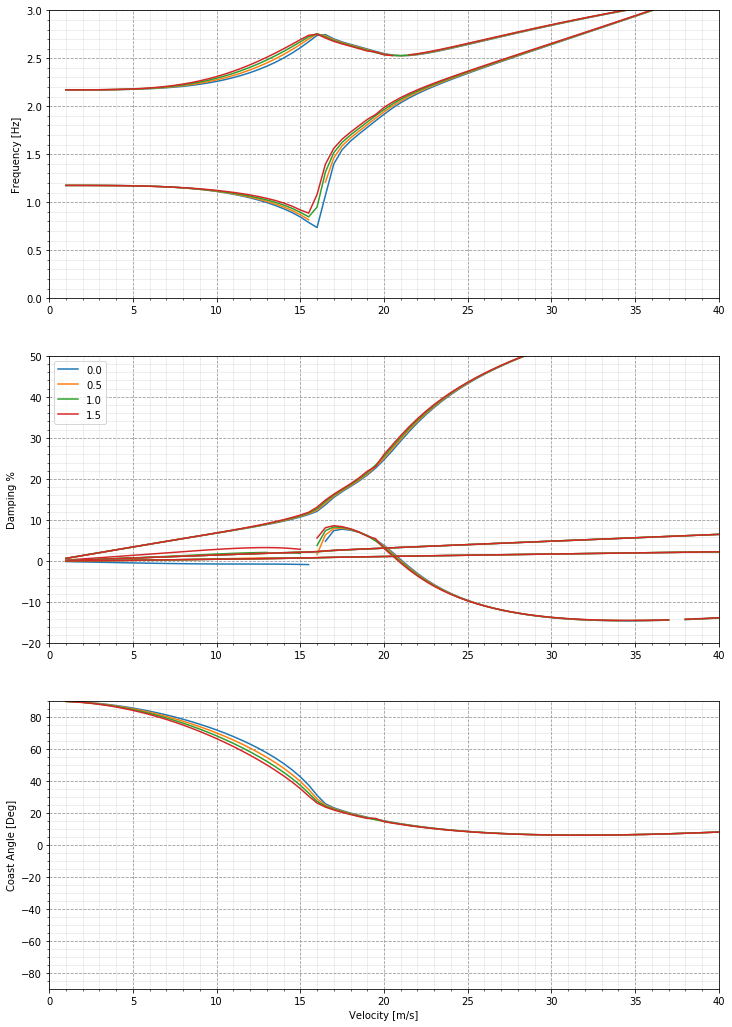

In [98]:
fig, axes = plt.subplots(3,1,figsize=(12,18))    

Tests = [5]
data = GetReducedDataSet(flutdf,Tests,ratio_FWT=20,FWT_mass = 100,c_dmax = None,Flare = 25,AoA = [5],Modes=[0,1,2,3],Stable=None)

PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = 'c_dmax',y = 'Frequency',ax = axes[0])
PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = 'c_dmax',y = 'Damping [%]',ax = axes[1])
CoastDeltaPlot(data,'c_dmax', axes[2],Delta = False)
print(np.unique(data['c_dmax']))
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,40))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,3))
axes[1].set(ylim=(-20,50))    
axes[2].set(ylim=(-90,90))  


#PlotModes(data,'Test',axes[:])
axes[1].legend([model_names[i] for i in Tests])
axes[1].legend(flutdf['c_dmax'].cat.categories)
#axes[1].legend(flutdf['AoA [Deg]'].cat.categories)
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

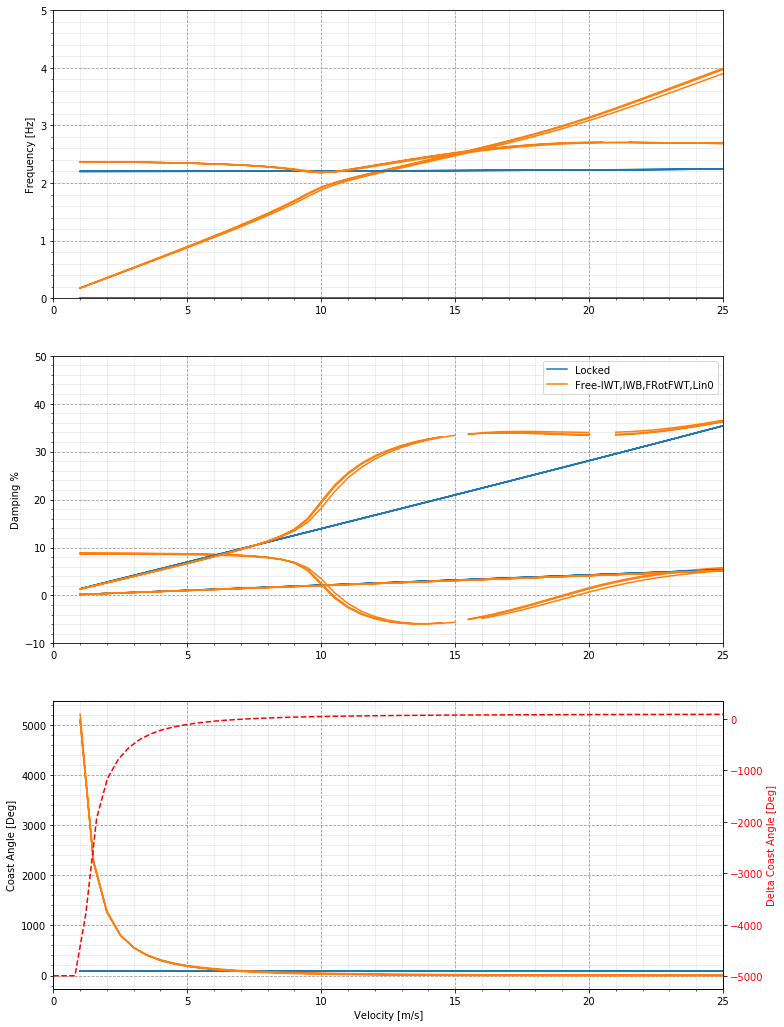

In [13]:
fig, axes = plt.subplots(3,1,figsize=(12,18))    

Tests = [0,5]
data = GetReducedDataSet(flutdf,Tests,Flare = 25,AoA = None,FWT_mass = 50, ratio_FWT = 10,Modes=[0,1,2])

PlotLines(data,x = 'V',sigma=8,Modes = flutdf['Mode'].cat.categories,hue = 'Model',y = 'Frequency',ax = axes[0])
PlotLines(data,x = 'V',sigma=8,Modes = flutdf['Mode'].cat.categories,hue = 'Model',y = 'Damping [%]',ax = axes[1])
CoastDeltaPlot(data,'Model', axes[2],Delta = True)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,25))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,5))
axes[1].set(ylim=(-10,50))    


#PlotModes(data,'Test',axes[:])
axes[1].legend([model_names[i] for i in Tests])
#fig.show()

## Compare FWT Ratios

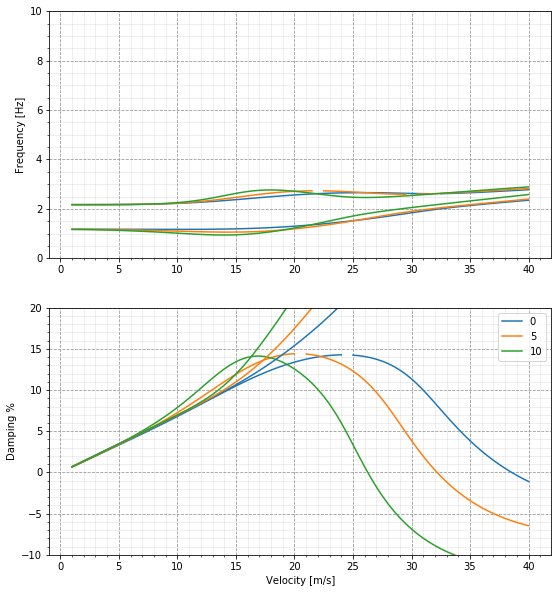

In [98]:
fig, axes = plt.subplots(2,1,figsize=(9,10))    

Tests = [3]
data = GetReducedDataSet(flutdf,Tests,ratio_FWT=[20],AoA = None, Flare = 10,Vmax=40,Modes=[0,1])

PlotLines(data, x = 'V', Modes = flutdf['Mode'].cat.categories,hue = 'AoA [Deg]',y = 'Frequency',ax = axes[0],sigma=5)
PlotLines(data, x = 'V', Modes = flutdf['Mode'].cat.categories,hue = 'AoA [Deg]',y = 'Damping [%]',ax = axes[1],sigma=5)

for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,140))
    #axes[i].set_xticks([i*20 for i in range(11)])
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,10))
axes[1].set(ylim=(-10,20))    


axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')
axes[1].set_xlabel('Velocity [m/s]')

#PlotModes(data,'Test',axes[:])
#axes[1].legend(['0%']*2+['10%']*2+['20%']*2,'30%'])
axes[1].legend([0,5,10])
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

In [146]:
a = [0,1,6,4,1,4]
np.unique(flutdf[flutdf['Mode']==1]['Test'])

array([0, 1, 2, 3, 4, 5, 6])

In [92]:
2.73==True

False

In [93]:
if 2.73:

SyntaxError: unexpected EOF while parsing (<ipython-input-93-cb3d0c20860b>, line 1)